In [56]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [35]:
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [36]:
#since the data file is tab separated .tsv, we read it using \t as separator 
meta = pd.read_csv("/Users/srijon/Projects/CS129 Final Project/MovieSummaries/movie.metadata.tsv", sep = '\t', header = None)

In [37]:
#rename columns : first -> ID, second ->mov_name, eight ->genre
meta.columns = ["movie_id", 1, "movie_name", 3,4,5,6,7,"genre"]

In [38]:
meta.head()

,movie_id,1,movie_name,3,4,5,6,7,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [39]:
#read plot summary from the textfile in dataset -- row has id and plot -- read by line 
plots = []

with open("/Users/srijon/Projects/CS129 Final Project/MovieSummaries/plot_summaries.txt", 'r') as f:
       reader = csv.reader(f, dialect='excel-tab') 
       for row in tqdm(reader):
            plots.append(row)
#split into two lists -- ids and plots 
movie_id = []
plot = []

#obtain these from lines read 
for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])
#create data frame 
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})
movies.head()

42303it [00:01, 32430.26it/s]
100%|██████████| 42303/42303 [00:00<00:00, 1445448.08it/s]


,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [41]:
# change datatype of 'movie_id'
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}"


In [42]:
#since the genres are in dictionary notation, convert them to python list 
movies['genre'][0]

'{"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"}'

In [43]:
type(json.loads(movies['genre'][0]))

dict

In [44]:
# an empty list
genres = [] 

# extract genres
for i in movies['genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genre_new'] = genres

In [45]:
#for movies without any genre tags, remove 
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [46]:
movies_new.shape, movies.shape

((41793, 5), (42204, 5))

In [47]:
movies.head()

,movie_id,plot,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}","[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


In [48]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

363

In [49]:
#create a dictionary of genres and their occurences 
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

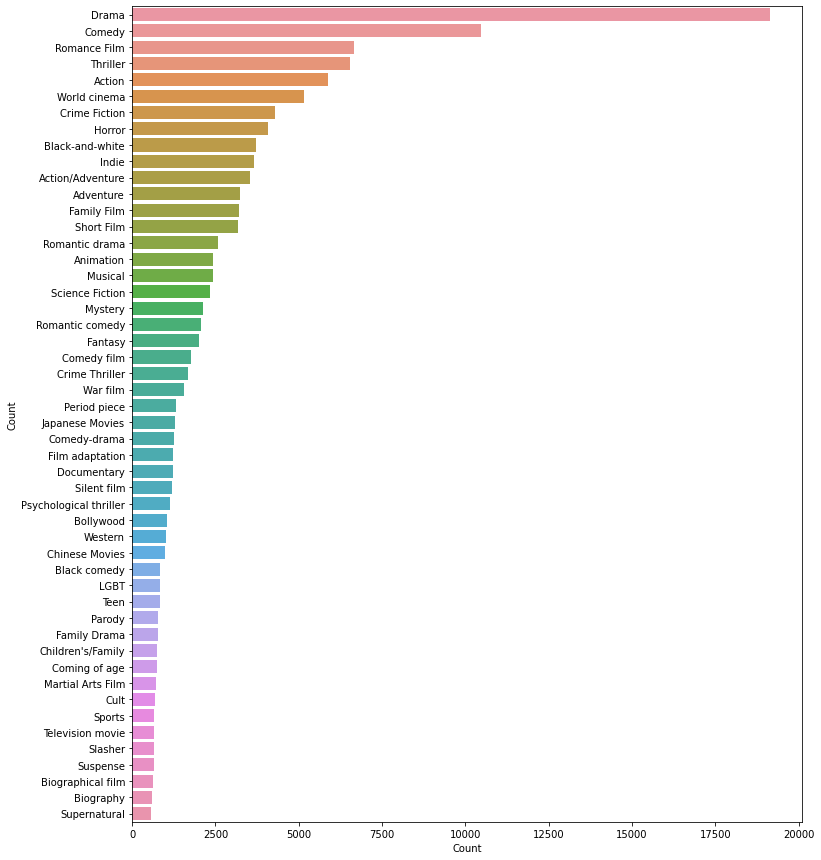

In [16]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [52]:
#cleaning the data -- 
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [53]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

In [18]:
movies_new.head()

,movie_id,plot,movie_name,genre,genre_new,clean_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}","[Drama, World cinema]",shlykov a hard working taxi driver and lyosha a saxophonist develop a bizarre love hate relationship and despite their prejudices realize they arent so different after all
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]",the nation of panem consists of a wealthy capitol and twelve poorer districts as punishment for a past rebellion each district must provide a boy and girl between the ages of and selected by lottery for the annual hunger games the tributes must fight to the death in an arena the sole survivor is...
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]",poovalli induchoodan is sentenced for six years prison life for murdering his classmate induchoodan the only son of justice maranchery karunakara menon was framed in the case by manapally madhavan nambiar and his crony dysp sankaranarayanan to take revenge on idealist judge menon who had earlier...
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]",the lemon drop kid a new york city swindler is illegally touting horses at a florida racetrack after several successful hustles the kid comes across a beautiful but gullible woman intending to bet a lot of money the kid convinces her to switch her bet employing a prefabricated con unfortunately ...
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]",seventh day adventist church pastor michael chamberlain his wife lindy their two sons and their nine week old daughter azaria are on a camping holiday in the outback with the baby sleeping in their tent the family is enjoying a barbecue with their fellow campers when a cry is heard lindy returns...


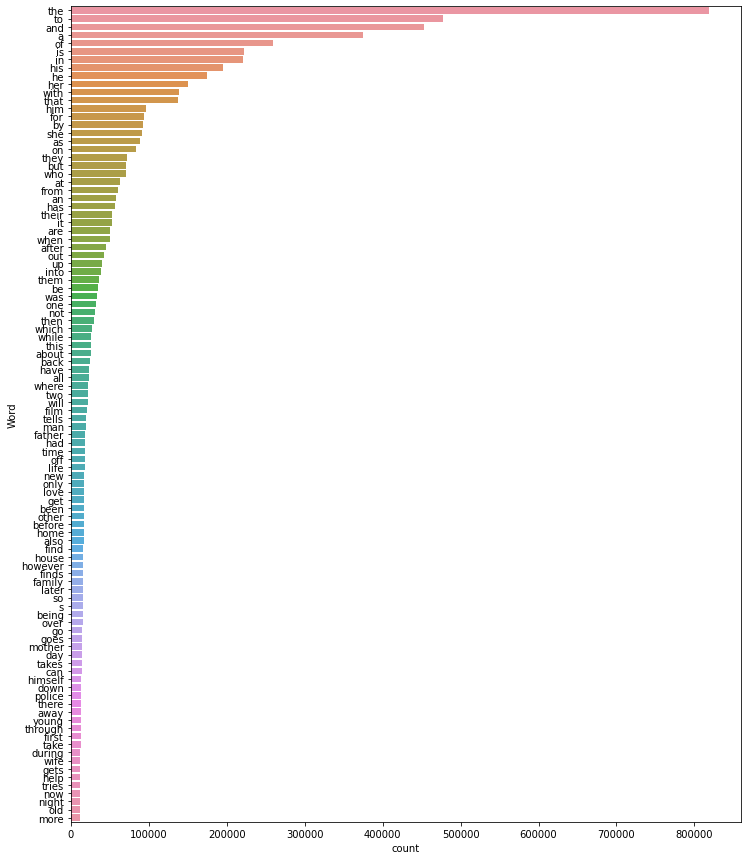

In [54]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(movies_new['clean_plot'], 100)

In [55]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

In [22]:
#convert genre tags into feature vectors
print("hi")

hi


In [20]:
#convert genres to feature vector of  0s and 1s

from sklearn.preprocessing import MultiLabelBinarizer

mb = MultiLabelBinarizer()
mb.fit(movies_new['genre_new'])

y = mb.transform(movies_new['genre_new'])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [21]:
#use 10,0000 most frequent words in data as feature set 
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)


In [22]:
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

In [23]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [24]:
#prediction 

from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [25]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

clf.fit(xtrain_tfidf,ytrain)
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [37]:
#retrieve genres from binary feature vector
mb.inverse_transform(y_pred)[2]

('Drama',)

In [54]:
# evaluate performance
f1_score(yval, y_pred, average="micro")


0.3156683206302113

In [39]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [42]:
#try a range of threshold values 
t= 0.1
while(t<1):
    # threshold value
    y_pred_new = (y_pred_prob >= t).astype(float) #was int -- i changd it
    # evaluate performance
    print(f1_score(yval, y_pred_new, average="micro"))
    
    t = t + 0.1
    

0.4345929389379402
0.4701317543060546
0.437668381092334
0.3808263695450326
0.3156683206302113
0.2376177116031001
0.16035661218424963
0.08790658360204114
0.029234067433248877
0.0


In [44]:
#inference function 
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return mb.inverse_transform(q_pred)

In [33]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",movies_new['genre_new'][k], "\n")

NameError: name 'infer_tags' is not defined

0.437668381092334

In [ ]:

from sklearn.svm import SVC
#from sklearn.metrics import accuracy_score, classification_report 
from sklearn import preprocessing
X_train = preprocessing.scale(xtrain_tfidf)
X_test = preprocessing.scale(xval_tfidf)
svm = OneVsRestClassifier(SVC())
svm.fit(X_train, X_test)

# Evaluating the model 
#print(f"Test Set Accuracy : {accuracy_score(xval_tfidf, prediction) * 100} %\n\n") 
#print(f"Classification Report : \n\n{classification_report(xval_tfidf, prediction)}") 

In [31]:
print("hi")

hi


In [30]:
from sklearn.model_selection import KFold
kf = kFold(n_splits =5)
kf.get_n_splits(xtrain_tfidf)

for train_index, test_index in kf.split(xtrain_tfidf):
    xtrain, xval = xtrain_tfidf[train_index], xtrain_tfidf[test_index]
    y_train, yval = ytrain[train_index], yval[test_index]


NameError: name 'kFold' is not defined